In [54]:
# %matplotlib inline

from __future__ import print_function
from sklearn import preprocessing
from time import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn import cross_validation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.text as mpl_text

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(1234)

In [3]:
#load 2015 and 2016 data into train and test data set 
horseData2015 = np.array(pd.read_excel('HorseCTrain.xlsx').values)
horseData2015 = np.vstack({tuple(row) for row in horseData2015})

horseData2016 = np.array(pd.read_excel('HorseCTest.xlsx').values)
horseData2016 = np.vstack({tuple(row) for row in horseData2016})

x_train = horseData2015[:, :-1];
y_train = horseData2015[:, -1:horseData2015[0].size];

x_test = horseData2016[:, :-1];
y_test = horseData2016[:, -1:horseData2016[0].size];

#smoooth y for both training and testing data
y_train = y_train.reshape(len(y_train),).astype(int) + (np.random.random_sample((len(y_train),))-1) + np.random.random_sample((len(y_train),))
y_test = y_test.reshape(len(y_test),).astype(int) + (np.random.random_sample((len(y_test),))-1) + np.random.random_sample((len(y_test),))

#smooth x_train for grid_search
X_train_smooth = preprocessing.scale(x_train)

In [4]:
def run_gp(regression_type, correlation_type, theta, nugget):
    trainX = x_train
    trainY = y_train
    testX = x_test
    testY = y_test
    testSet = x_test

    gp = gaussian_process.GaussianProcess(regr=regression_type,
                                          corr=correlation_type,
                                          theta0=theta,
                                          nugget=nugget)
    gp.fit(x_train, y_train)

    predictedY, MSE = gp.predict(x_test, eval_MSE = True)
    sigma = np.sqrt(MSE)

    results = {}
    results['predictedY'] = predictedY
    results['sigma'] = sigma

    train_score = gp.score(x_train, y_train)
    test_score = sklearn.metrics.r2_score(y_test, predictedY)
    
    return train_score, test_score

In [5]:
# regression, correlation, theta, nugget
models = [
            ['linear', 'squared_exponential', 0.02, 0.02],
            ['linear', 'cubic', 0.04, 0.005],
            ['linear', 'absolute_exponential', 0.005, 0.01],
            ['linear', 'linear', 0.005, 0.01],
            ['constant', 'squared_exponential', 0.005, 0.015],
            ['constant', 'cubic', 0.03, 0.005],
            ['constant', 'absolute_exponential', 0.005, 0.02],
            ['constant', 'linear', 0.005, 0.02]
        ]

In [6]:
training_scores = []
test_scores = []

for model in models:
    training_score, test_score = run_gp(model[0], model[1], model[2], model[3])
    training_scores.append(training_score)
    test_scores.append(test_score)

In [7]:
test_scores

[0.62957462133683872,
 0.60548399661444174,
 0.74907615111788339,
 0.74915949137908266,
 0.48714508233202258,
 0.66058819528860968,
 0.80808153767054292,
 0.80808810982011237]

In [64]:
training_scores

[0.97124634767600293,
 0.947699550484986,
 0.97103671510263934,
 0.97108431872235035,
 0.87947233046249373,
 0.91348110197557397,
 0.95278894321643293,
 0.95286062820998541]

In [33]:
N = len(models)
index = np.arange(N)
bar_width = 0.3

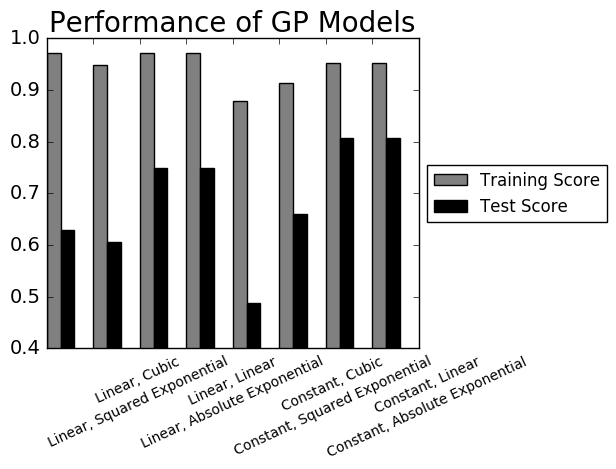

In [63]:
fig, ax = plt.subplots()
rects1 = ax.bar(ind, training_scores, width, color='grey', label='Training Score')
rects2 = ax.bar(ind+width, test_scores, width, color='black', label='Test Score')

ax.set_ylim(0.4, 1)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.set_xticklabels(('Linear, Squared Exponential', 
                    'Linear, Cubic', 
                    'Linear, Absolute Exponential',
                    'Linear, Linear',
                    'Constant, Squared Exponential',
                    'Constant, Cubic',
                    'Constant, Absolute Exponential',
                    'Constant, Linear'),
                   rotation=25,
                   ha='left')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.set_title('Performance of GP Models', fontsize=20)
ax.legend(loc='center left',
          bbox_to_anchor=(1, 0.5))

plt.show()